In [1]:
# Data Manipulation
#-----------------------------
import pandas as pd

# Data Visualisation
#-----------------------------
import seaborn as sns

# Natural Laguage Processing
#-----------------------------
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')

# Sci-kit learn packages
#-----------------------------
# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modelling
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score


# Other packages
#-----------------------------
import string
import re

from time import time


[nltk_data] Downloading package stopwords to
[nltk_data]   Package stopwords is already up-to-date!


# Import the dataframe

In [3]:
df_lyrics = pd.read_csv('../Data/Processed Data/clean_lyrics.csv', keep_default_na = False)

In [4]:
df_lyrics.head(3)

,SName,Lyric,Artist,Genre,multiple_letter,Trails,lyrics_clean,Rock,Pop,Hip_hop
0,World So Cold,"It starts with pain, followed by hate. Fueled ...",12 Stones,0,0.0,0,start pain follow hate fuel endless question o...,1,0,1
1,Broken,Freedom!. Alone again again alone. Patiently w...,12 Stones,0,0.0,0,freedom alon alon patient wait phone hope call...,1,1,0
2,3 Leaf Loser,"Biting the hand that feeds you, lying to the v...",12 Stones,0,0.0,0,bite hand feed lie voic insid reach beg someth...,1,1,0


In [5]:
df_lyrics.shape

(79452, 10)

In [6]:
df_lyrics.groupby('Genre')['Trails'].mean()

Genre
0    1.795946
1    9.277079
2    2.151848
Name: Trails, dtype: float64

# Logistic Regression

## Regression using the lyrics only

We will first experiment with different parameters of MultiClass Logistic Regression, using the lyrics only.
In the df_lyrics dataframe, the lyrics were stemmed using the SnowBall stemmer. However, in this notebook, we will go through the other stemmers as well, to study if they will have any impact on the model performance.

We will measure the time it takes for each model to be fitted as well.

In [7]:
import multiprocessing
print(f'Your number of available CPU workers is: {multiprocessing.cpu_count()}')

Your number of available CPU workers is: 4


In [8]:
def apr(y_pred, y_real):
    
    '''This function takes in the real and predicted values of the target.
    It returns the following performance metrics: accuracy, precision, recall and F1-score'''
    
    accuracy = accuracy_score(y_real, y_pred) ## From sklearn, get the accuracy
    precision = precision_score(y_real, y_pred, average='weighted') ## precision
    recall = recall_score(y_real, y_pred, average='weighted') ## recall
    f1 = f1_score(y_real, y_pred, average='weighted') ## F1
    
    ''' Print them into a readable format '''
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f'F1:{f1}')
    
    return accuracy, precision, recall, f1 ## return them in case we need to save them in non-local variables

### SnowBall Stemmer

In this section, we carry out several Multiclass Logistic Regressions, using different solvers and penalties.
The order is as follow:
 1. Default solver and penalty
 2. Saga solver, default penalty (L2)
 3. Saga solver, Elasticnet penalty
 4. Saga solver, L1 penalty
 5. Newton solver, default penalty (L2)
 6. Newton solver, default penalty (L2), different regularization strength

In [9]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 1000)

#### Pre-processing

##### Features and target sets

In [10]:
X = df_lyrics['lyrics_clean']
y = df_lyrics['Genre']

##### Train/Test split

In [11]:
# We stratify the sets, as the classes are not well balanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

##### Vectorization

In [12]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### 1. Basic Model Fitting

In [ ]:
now = time()
lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)
print("Time elapsed in seconds: {}".format(time()-now))

Because of the important number of features, we will consistantly get a 'failure to converge '. For better readability, we simply remove the warnings. We tested the code beforehand, to make sure that we were not getting any other type of warning.

In [14]:
import warnings
warnings.filterwarnings("ignore")


##### Training Set Metrics

In [15]:
## Output the metrics using the apr() function

apr(lr.predict(X_train), y_train)

Accuracy:0.7595538144459653
Precision:0.7512110021169807
Recall:0.7595538144459653
F1:0.7434242598538158


(0.7595538144459653,
 0.7512110021169807,
 0.7595538144459653,
 0.7434242598538158)

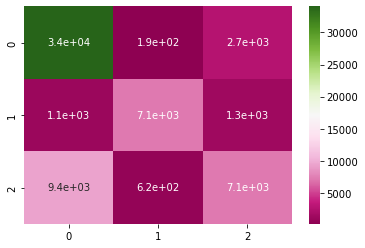

In [16]:
conf_train = confusion_matrix(y_train, lr.predict(X_train))
matrix = sns.heatmap(conf_train, annot = True, cmap="PiYG")

##### Testing Set Metrics

In [17]:
apr(lr.predict(X_test), y_test)

Accuracy:0.747152476244415
Precision:0.7367041148483754
Recall:0.747152476244415
F1:0.7315343980178692


(0.747152476244415, 0.7367041148483754, 0.747152476244415, 0.7315343980178692)

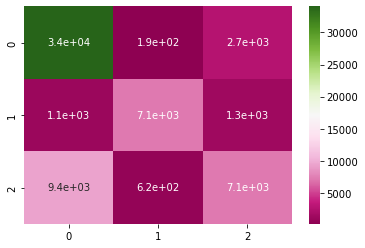

In [18]:
conf = confusion_matrix(y_train, lr.predict(X_train))
matrix = sns.heatmap(conf, annot = True, cmap="PiYG")

#### 2. Saga solver, default penalty (L2)

In [19]:
now=time()
lr_opt = LogisticRegression(max_iter=200, solver='saga', n_jobs = multiprocessing.cpu_count()-1, C=1)
lr_opt.fit(X_train, y_train)
print("Time elapsed in seconds: {}".format(time()-now))
apr(lr_opt.predict(X_test), y_test)

Time elapsed in seconds: 30.9097900390625
Accuracy:0.7372726700648166
Precision:0.7259674584834424
Recall:0.7372726700648166
F1:0.7236460189146265


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0.7372726700648166,
 0.7259674584834424,
 0.7372726700648166,
 0.7236460189146265)

#### 3. Saga solver, Elasticnet penalty

In [20]:
now=time()
lr_opt_split = LogisticRegression(max_iter=200, solver='saga',penalty='elasticnet',
                              l1_ratio=.5, n_jobs = multiprocessing.cpu_count()-1, C=1)
lr_opt_split.fit(X_train, y_train)
print("Time elapsed in seconds: {}".format(time()-now))
apr(lr_opt_split.predict(X_test), y_test)

Time elapsed in seconds: 178.0121066570282
Accuracy:0.7373355987665975
Precision:0.7259319971492063
Recall:0.7373355987665975
F1:0.7236853222490761


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0.7373355987665975,
 0.7259319971492063,
 0.7373355987665975,
 0.7236853222490761)

#### 4. Saga solver, L1 penalty

In [21]:
now=time()
lr_opt_one = LogisticRegression(max_iter=200, solver='saga',penalty='l1',
                               n_jobs = multiprocessing.cpu_count()-1, C=1)
lr_opt_one.fit(X_train, y_train)
print("Time elapsed in seconds: {}".format(time()-now))
apr(lr_opt_one.predict(X_test), y_test)

Time elapsed in seconds: 159.19625759124756
Accuracy:0.7373355987665975
Precision:0.7258974588505711
Recall:0.7373355987665975
F1:0.7235953755985124


F:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0.7373355987665975,
 0.7258974588505711,
 0.7373355987665975,
 0.7235953755985124)

#### 5. Newton solver, default penalty (L2)

In [22]:
now=time()
lr_opt_newt = LogisticRegression(max_iter=200, solver='newton-cg',penalty='l2',
                               n_jobs = multiprocessing.cpu_count()-1, C=1)
lr_opt_newt.fit(X_train, y_train)
print("Time elapsed in seconds: {}".format(time()-now))
apr(lr_opt_newt.predict(X_test), y_test)

Time elapsed in seconds: 65.59594011306763
Accuracy:0.747152476244415
Precision:0.7366482703738324
Recall:0.747152476244415
F1:0.7314587352672967


(0.747152476244415, 0.7366482703738324, 0.747152476244415, 0.7314587352672967)

#### 6. Newton solver, default penalty (L2), different inverse of regularization strength (C)

In [23]:
C_set = [10,20,30,40,50,60,70,80,90,100]
for regular in C_set:
    lr_opt_newt_C = LogisticRegression(max_iter=200, solver='newton-cg',penalty='l2',
                               n_jobs = multiprocessing.cpu_count()-1, C=regular)
    lr_opt_newt_C.fit(X_train, y_train)
    print(f'The score for C={regular} is {lr_opt_newt_C.score(X_test, y_test)}', "\n")

The score for C=10 is 0.7474671197533195 

The score for C=20 is 0.7475300484551004 

The score for C=30 is 0.7475300484551004 

The score for C=40 is 0.7475300484551004 

The score for C=50 is 0.7475300484551004 

The score for C=60 is 0.7475300484551004 

The score for C=70 is 0.7475300484551004 

The score for C=80 is 0.7475300484551004 

The score for C=90 is 0.7475300484551004 

The score for C=100 is 0.7475300484551004 



#### Summary

For C=1 (default value), we have:

| | **Base** | **L1 Saga** | **L2 Saga**|  **Elastic Saga** | **Newton** |
| -------------- | -------------- | ------------- | ------------- | ------------- | ------------- |
| **Accuracy** | 71.29 % | 71.32 % | 71.31 % | 71.34 % | 71.35 % |
| **Precision** | 70.41 % | 70.46 % | 70.40 % | 70.48 % | 70.48 % |
| **Recall** | 71.29 % | 71.32 % | 71.31 % | 70.48 % | 71.35 % | 
| **F1** | 69.70 % | 71.32 % | 71.31% | 71.34 % | 69.76 % |


##### Things to considere to improve the metrics:


- Try performance WITH the features enrichment (columns: Rock, Pop, Hip_hop, multiple_letter, Trails)

- Try all permutations (with/without FE) of stemmers

- Change seed and/or split size = Run k-fold CV

## GridSearch

(Do not run, very time consuming)

In [24]:
# lr_params = {
#     'C': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     'solver' : ['newton-cg', 'saga'],
#     'max_iter' : [200],
#     'n_jobs' : [multiprocessing.cpu_count()-1],
#     'multi_class': ['ovr', 'multinomial']
# }

# ## Perform the grid search

# gs = GridSearchCV(LogisticRegression(), param_grid=lr_params, cv=10)

# ## Fit the models

# gs.fit(X_train, y_train)

# ## Output the best score only

# print(gs.best_score_)

# ## Get the parameters for the best estimator

# gs.best_estimator_

_Cross Validation Score_

In [25]:
# lr_score = cross_val_score(LogisticRegression(max_iter=200, solver='saga',penalty='l1',
#                                n_jobs = multiprocessing.cpu_count()-1, C=1), X_train, y_train, cv=10)
# print("The knn score on 10-fold CV against overfitting, on a scale 0.000 - 1.000 is {}.".format(np.std(lr_score)))

### Other stemming approaches

In [26]:
stpwrds = stopwords.words('english') # Import the list of stopwords.
string.punctuation # Import the list of punctuation.
stpwrds.extend(string.punctuation) # Merge the 2 lists together.

#  Add chorus and verse to the list, as they are not part of the lyrics
stpwrds.extend(['chorus', 'verse', 'verses', 'choruses'])
                                        

#### Function Declaration

In [27]:
def regex_clean(txt, regex, sub=' '):
    
    '''This function takes in a string and a regular expression.
    It will clean the string by removing any match from the regular expression.
    
    The output is the cleaned string'''
        
    return " ".join(re.sub(regex, sub, txt).split()) ## Substitute the desired regex with nothing,
                                                    ## then bring the sentence back together

In [31]:
p_stemmer = PorterStemmer()
l_stemmer = LancasterStemmer()
s_stemmer = SnowballStemmer(language='english')

In [32]:
def prep_data(song, stem='s'):
    ''' This function takes in a string, clean it using regular expressions, tokenize it, remove
    digits and any word shorter than 2 characters.
    
    It returned the clean and tokenized version of the string'''
    assert(stem=='s' or stem=='l' or stem=='p'), '''Input a correct stemming parameter and try again.
    The only accepted types are s for Snowball, l for Lancaster or p for Porter. Default is Snowball.'''
    
    song = song.lower() ## Transform the sentence into lowercase

    song = regex_clean(song, r'(\w)\1{2,}', r'\1') # Removing all trailing '
    song = regex_clean(song, r"'\s|'\.", r'g') # Removing triple letters or more.
    song = regex_clean(song, r'(\[.*?\])', r'') # Removing any characeters inside brackets (including brackets)
    song = regex_clean(song, r'(\W){2,}', r'\1') # Removing trailing white space
    
    ## Tokenize 
    song = nltk.wordpunct_tokenize(song) ## tokenize the string

    ## Post Token Cleaning - Stuff that applies to a list 
        
    song = [word for word in song if word not in stpwrds] # Eliminate all extended stopwords from among our tokens
    song = [globals()['{}_stemmer'.format(stem)].stem(word) for word in song] # Apply the chosen stemmer
    song = [word for word in song if not word.isdigit()] # Remove all digits
    song = [word for word in song if len(word)>2] # Remove words shorter than 2 characters, to avoid 'de, tg, ll' etc.


    return song

We first clean the lyrics, using the different stemmers.

In [33]:
lyrics_porter = [" ".join(prep_data(x, 'p')) for x in df_lyrics['Lyric']]
lyrics_lanc = [" ".join(prep_data(x, 'l')) for x in df_lyrics['Lyric']]

#### Feature and target sets

In [34]:
Porter = pd.Series(lyrics_porter) # Feature set for the Porter stemmer
Lanc = pd.Series(lyrics_lanc) # Feature set for the Lancaster stemmer

y = df_lyrics['Genre'] # Target set

In [35]:
Porter_train, Porter_test, y_train_Porter, y_test_Porter = train_test_split(Porter.copy(), y.copy(), test_size = 0.2, 
                                                                            random_state = 42, stratify=y)

Lanc_train, Lanc_test, y_train_Lanc, y_test_Lanc = train_test_split(Lanc.copy(), y.copy(), test_size = 0.2,
                                                                    random_state = 42, stratify=y)

In [36]:
Porter_train = vectorizer.fit_transform(Porter_train)
Lanc_train = vectorizer.fit_transform(Lanc_train)

Porter_test = vectorizer.transform(Porter_test)
Lanc_test = vectorizer.transform(Lanc_test)

#### _Porter version_

In [ ]:
now = time()
lr_port = LogisticRegression(max_iter=200)
lr_port.fit(Porter_train, y_train_Porter)
print("Time elapsed in seconds: {}".format(time()-now))

In [42]:
apr(lr_port.predict(Porter_test), y_test_Porter)

Accuracy:0.5605688754640992
Precision:0.5036010993945575
Recall:0.5605688754640992
F1:0.5158180629774124


(0.5605688754640992,
 0.5036010993945575,
 0.5605688754640992,
 0.5158180629774124)

#### _Lancaster version_

In [ ]:
now = time()
lr_lan = LogisticRegression(max_iter=200)
lr_lan.fit(Lanc_train, y_train_Lanc)
print("Time elapsed in seconds: {}".format(time()-now))

In [43]:
apr(lr_lan.predict(Lanc_test), y_test_Lanc)

Accuracy:0.74608268831414
Precision:0.7350863966353448
Recall:0.74608268831414
F1:0.7299560506110782


(0.74608268831414, 0.7350863966353448, 0.74608268831414, 0.7299560506110782)


_**Assumption:**_ Improvements resulting directly from versions/parameter choices/parameter tuning when it comes to :

    1) Stemming,
    
    2) Model hyperparameter tuning (C, penalty, solver),
    
    3) CV, split, seed choice,
    
    4) Vectorizing parameters,
    
    5) Feature Enrichment.
    
are _independent performance enhancers_ - that is - they **do not** affect each other and can be optimally combined by choosing the best iteration from all categories.

<u>Example:</u> If for criteria A, exhibit a is better than b and/or c ; and for criteria B exhibit x is better than y and/or z : Then the optimal model performance is achieved by selecting exhibit a from criteria A and exhibit x from criteria B. Any other combination: (a,y), (a,z), (b,x), (b,y), (b,z), (c,x), (c,y), (c,z) will yield a worse performance. This claim is necesarilly true and universally follows if and only if the assumption provided above is considered.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

With these considerations, the ideal parameters of choice were:

    1) Snowball stemmer

    2) Newton solver on ridge penalization, with balanced point regularisation (C=1) and EPP'd.

    3) Irrelevant to selection: let split = 80%, seed=42

    4) Performance slightly increases with features considered, but so does memory - at a quadratic* faster rate. Select 1000 for best memory performance, 5000 for best accuracy performance.

    5) Trails + Word frequency columns